In [70]:
import os
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities, modularity
from collections import Counter, defaultdict, Counter
from scipy.stats import pearsonr, spearmanr, kendalltau, poisson, expon
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
import powerlaw


recipes_graph = nx.read_gml("final_recipe_graph_min_common_6.gml")

In [71]:
for node in recipes_graph.nodes(data=True):
    print(node)


('522861', {'name': 'lplermagrone', 'num_ingredients': 8, 'ingredients': ['Milk', 'salt', 'macaroni', 'cheese', 'pepper', 'butter', 'onion', 'garlic']})
('523359', {'name': 'der wiener schnitzel style chili dog sauce', 'num_ingredients': 14, 'ingredients': ['beef', 'pork', 'water', 'cornstarch', 'flour', 'tomato', 'chili', 'Paprika', 'vinegar', 'salt', 'onion', 'sugar', 'garlic', 'pepper']})
('513531', {'name': 'better than a can  homemade sloppy joes', 'num_ingredients': 18, 'ingredients': ['olive oil', 'onion', 'pepper', 'pepper', 'celery', 'garlic', 'tomato', 'tomato', 'ketchup', 'vinegar', 'Molasses', 'Worcestershire', 'mushroom', 'tomato', 'oregano', 'beef', 'pepper', 'buns']})
('535020', {'name': 'buffalo wing  mushrooms', 'num_ingredients': 8, 'ingredients': ['mushroom', 'cornstarch', 'flour', 'salt', 'pepper', 'seltzer', 'panko', 'oil']})
('519068', {'name': 'dorito  popcorn seasoning', 'num_ingredients': 8, 'ingredients': ['yeast', 'garlic', 'onion', 'cumin', 'Paprika', 'chili

## Do recipes from the same cuisine form distinct communities within the graph?


In [72]:
def randomize_graph(graph):
    randomized_graph = nx.algorithms.smallworld.random_reference(graph, connectivity=False)
    return randomized_graph

In [73]:
def print_total_communities_and_modularity(G, method, communities):
    total_communities = len(communities)
    modularity_value = modularity(G, communities)
    print(f"{method} - Total Communities: {total_communities}, Modularity: {modularity_value:.4f}")

def communities_greedy_label_summary(G, dataset_name):
    greedy_communities = list(greedy_modularity_communities(G))
    print_total_communities_and_modularity(G, "Greedy Modularity", greedy_communities)

    label_communities = list(label_propagation_communities(G))
    print_total_communities_and_modularity(G, "Label Propagation", label_communities)

print("\n=== Greedy and Label ===")
communities_greedy_label_summary(recipes_graph, 'Graph 6 Common Ingredients')

print("\n=== Randomized ===")
recipes_randomized = randomize_graph(recipes_graph)
communities_greedy_label_summary(recipes_randomized, 'Graph 6 Common Ingredients Randomized')


=== Greedy and Label ===
Greedy Modularity - Total Communities: 437, Modularity: 0.4268
Label Propagation - Total Communities: 434, Modularity: 0.4103

=== Randomized ===
Greedy Modularity - Total Communities: 442, Modularity: 0.0885
Label Propagation - Total Communities: 426, Modularity: 0.0000


In [74]:
def print_communities_by_name(G, method, communities):
    print(f"\n{method}:")
    for i, community in enumerate(communities):
        node_names = [G.nodes[node]['name'] for node in community]
        print(f"\nCommunity {i+1} ({len(node_names)} recipes):")
        for idx, name in enumerate(node_names, start=1):
            print(f"  {idx}. {name}")
    print(f"\nTotal number of communities: {len(communities)}")
    print(f"Modularity: {modularity(G, communities):.4f}")

def communities_greedy_label(G, dataset_name):
    greedy_communities = list(greedy_modularity_communities(G))
    print_communities_by_name(G, "Greedy Modularity", greedy_communities)

    label_communities = list(label_propagation_communities(G))
    print_communities_by_name(G, "Label Propagation", label_communities)

In [75]:
communities_greedy_label(recipes_graph, 'Graph 6 Common Ingredients')


Greedy Modularity:

Community 1 (779 recipes):
  1. dried cherry and goat cheese salad with dijon vinaigrette
  2. slow cooker chicken burrito bowls
  3. collard greens mac   cheese
  4. crock pot chicken taco chili
  5. best copycat benihana japanese chicken rice
  6. breakfast muffins to go
  7. gorky s chicken
  8. pecorino crusted chicken with mushroom salad
  9. greek with envy
  10. caprese stuffed avocado
  11. crisp roasted broccoli
  12. pasta in almond garlic sauce
  13. dr  oz s 2 week rapid weight loss plan  vegetable broth
  14. taco bell style crunch wrap supreme
  15. baked sea bass with vegetables
  16. crab cake stuffed mushrooms
  17. lemon chicken and spaghetti squash
  18. brazilian shrimp stew
  19. janet s kfc seasoned fried chicken
  20. skillet linguica with pasta
  21. vegan collard greens
  22. polenta   sausage stuffed pepper gondolas  ragu
  23. mashup mexican lasagna
  24. touchdown turkey chili
  25. bistec argentino al chimichurri  steak with chimichurri

## Which ingredients act as ”bridges” between different cuisines?

In [76]:

def analyze_communities(G, communities):
    analysis_results = []

    for i, community in enumerate(communities):
        recipe_names = [G.nodes[node]['name'] for node in community]

        all_ingredients = []
        for node in community:
            all_ingredients.extend(G.nodes[node].get('ingredients', []))

        ingredient_counts = Counter(all_ingredients)
        most_common_ingredients = ingredient_counts.most_common(10) 

        avg_num_ingredients = np.mean([G.nodes[node]['num_ingredients'] for node in community])

        analysis_results.append({
            "community": i + 1,
            "num_recipes": len(community),
            "most_common_ingredients": most_common_ingredients,
            "avg_num_ingredients": avg_num_ingredients,
            "recipe_names": recipe_names
        })

    return analysis_results


def print_community_analysis(results):
    for result in results:
        print("=" * 50)
        print(f"Community {result['community']}")
        print(f"Number of Recipes: {result['num_recipes']}")
        print(f"Average Number of Ingredients: {result['avg_num_ingredients']:.2f}")
        print("\nMost Common Ingredients:")
        for ingredient, count in result['most_common_ingredients']:
            print(f"  - {ingredient} ({count} times)")

        print("\nFirst 20 Recipes:")
        for idx, name in enumerate(result['recipe_names'][:20], start=1):
            print(f"  {idx}. {name}")
        print("=" * 50)



In [77]:
def find_bridge_ingredients(G, communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i

    bridge_ingredients = []
    for u, v in G.edges():
        if node_to_community[u] != node_to_community[v]:
            ingredients_u = set(G.nodes[u].get('ingredients', []))
            ingredients_v = set(G.nodes[v].get('ingredients', []))
            common_ingredients = ingredients_u.intersection(ingredients_v)
            bridge_ingredients.extend(common_ingredients)

    ingredient_counts = Counter(bridge_ingredients)

    return ingredient_counts

In [78]:


def find_bridge_ingredients_with_details(G, communities):
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i + 1  

    bridge_ingredient_details = defaultdict(list)

    for u, v in G.edges():
        community_u = node_to_community[u]
        community_v = node_to_community[v]
        if community_u != community_v:
            ingredients_u = set(G.nodes[u].get('ingredients', []))
            ingredients_v = set(G.nodes[v].get('ingredients', []))
            common_ingredients = ingredients_u.intersection(ingredients_v)
            for ingredient in common_ingredients:
                bridge_ingredient_details[ingredient].append({
                    "recipe_u": G.nodes[u]['name'],
                    "community_u": community_u,
                    "recipe_v": G.nodes[v]['name'],
                    "community_v": community_v
                })

    return bridge_ingredient_details


In [79]:
greedy_communities = list(greedy_modularity_communities(recipes_graph))
community_analysis_results = analyze_communities(recipes_graph, greedy_communities)
print_community_analysis(community_analysis_results)

Community 1
Number of Recipes: 779
Average Number of Ingredients: 12.74

Most Common Ingredients:
  - pepper (720 times)
  - salt (665 times)
  - garlic (605 times)
  - onion (594 times)
  - olive oil (351 times)
  - chicken (226 times)
  - butter (184 times)
  - tomatoes (174 times)
  - tomato (159 times)
  - lemon (158 times)

First 20 Recipes:
  1. dried cherry and goat cheese salad with dijon vinaigrette
  2. slow cooker chicken burrito bowls
  3. collard greens mac   cheese
  4. crock pot chicken taco chili
  5. best copycat benihana japanese chicken rice
  6. breakfast muffins to go
  7. gorky s chicken
  8. pecorino crusted chicken with mushroom salad
  9. greek with envy
  10. caprese stuffed avocado
  11. crisp roasted broccoli
  12. pasta in almond garlic sauce
  13. dr  oz s 2 week rapid weight loss plan  vegetable broth
  14. taco bell style crunch wrap supreme
  15. baked sea bass with vegetables
  16. crab cake stuffed mushrooms
  17. lemon chicken and spaghetti squash
  

In [80]:
bridge_ingredient_counts = find_bridge_ingredients(recipes_graph, greedy_communities)

print(f"{'Rank':<5} {'Ingredient':<25} {'Number of Connections'}")
print("=" * 50)
for rank, (ingredient, count) in enumerate(bridge_ingredient_counts.most_common(), start=1):
    print(f"{rank:<5} {ingredient:<25} {count}")

Rank  Ingredient                Number of Connections
1     salt                      1764
2     garlic                    1391
3     pepper                    1238
4     onion                     1093
5     flour                     851
6     sugar                     769
7     oil                       579
8     butter                    531
9     water                     468
10    egg                       422
11    chicken                   328
12    Milk                      326
13    ginger                    231
14    carrot                    206
15    vinegar                   191
16    soy                       186
17    eggs                      171
18    cheese                    153
19    rice                      138
20    chili                     137
21    cornstarch                121
22    mustard                   93
23    cilantro                  91
24    baking                    88
25    olive oil                 86
26    parmesan                  81
27    scall

In [81]:
bridge_ingredient_details = find_bridge_ingredients_with_details(recipes_graph, greedy_communities)

print("=" * 120)
print(f"{'Ingredient':<20} {'Recipe 1 (Community)':<45} {'Recipe 2 (Community)':<45}")
print("=" * 120)

for ingredient, connections in bridge_ingredient_details.items():
    print(f"\nIngredient: {ingredient}")
    for connection in connections[:10]: 
        print(f"  - {connection['recipe_u']} (Community {connection['community_u']}) "
              f"<-> {connection['recipe_v']} (Community {connection['community_v']})")
    print("-" * 120)

Ingredient           Recipe 1 (Community)                          Recipe 2 (Community)                         

Ingredient: cheese
  - lplermagrone (Community 1) <-> mac and jack and cheese (Community 4)
  - lplermagrone (Community 1) <-> traditional style pastitsio  ragu (Community 4)
  - 1 minute breakfast sandwich (Community 4) <-> lets talk turkey  burgers with chipotle mayo   a1 (Community 1)
  - 4 delicious french fry toppers (Community 1) <-> traditional style pastitsio  ragu (Community 4)
  - 7 layer elote dip (Community 1) <-> momaphet s cilantro lime cornbread (Community 2)
  - a 1 steak puffs with corn and avocado salsa  a1 (Community 1) <-> momaphet s cilantro lime cornbread (Community 2)
  - a 1 steak puffs with corn and avocado salsa  a1 (Community 1) <-> traditional style pastitsio  ragu (Community 4)
  - a 1 steak puffs with corn and avocado salsa  a1 (Community 1) <-> yummy corn cakes (Community 2)
  - acili biskuvi  spicy biscuits (Community 4) <-> copycat chick fil

## What are the most versatile or influential recipes based on their graph connectivity?

In [82]:
def compute_centralities(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    
    return {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality,
        'eigenvector': eigenvector_centrality
    }

def get_top_recipes(graph, centralities, centrality_type='degree', top_n=10):
    if centrality_type not in centralities:
        raise ValueError("Invalid centrality type. Choose from ['degree', 'betweenness', 'closeness', 'eigenvector']")
    
    sorted_centralities = sorted(centralities[centrality_type].items(), key=lambda x: x[1], reverse=True)
    sorted_centralities = [(graph.nodes[node]['name'], centrality) for node, centrality in sorted_centralities]
    return sorted_centralities[:top_n] 



def get_top_recipes_by_frequency(graph, centralities, top_n=5):
    all_top_recipes = []
    
    for centrality_type in ['degree', 'betweenness', 'closeness', 'eigenvector']:
        top_recipes = get_top_recipes(graph, centralities, centrality_type=centrality_type, top_n=top_n)
        all_top_recipes.extend([recipe[0] for recipe in top_recipes]) 
    
    recipe_counts = Counter(all_top_recipes)
    
    top_recipes_by_frequency = recipe_counts.most_common(top_n)
    
    return top_recipes_by_frequency

In [83]:
def centralities_info(graph, graph_name):
    
    centralities = compute_centralities(graph)
    print(f"Centralities for {graph_name}: {centralities}")

    top_recipes_by_frequency = get_top_recipes_by_frequency(graph, centralities, top_n=5)
    print(f"Top Recipes by Frequency across Centralities in {graph_name}:")
    for recipe, count in top_recipes_by_frequency:
        print(f"{recipe}: {count} times")
    

In [84]:
centralities_info(recipes_graph, "Recipe network with min. 6 common ingredients")

Centralities for Recipe network with min. 6 common ingredients: {'degree': {'522861': 0.013310185185185185, '523359': 0.0949074074074074, '513531': 0.027199074074074073, '535020': 0.0005787037037037037, '519068': 0.02199074074074074, '535431': 0.0023148148148148147, '532472': 0.05844907407407407, '533190': 0.0011574074074074073, '531143': 0.0005787037037037037, '525649': 0.10821759259259259, '531148': 0.0005787037037037037, '517511': 0.009259259259259259, '513216': 0.008680555555555556, '516214': 0.009837962962962962, '520809': 0.09201388888888888, '531161': 0.010416666666666666, '513291': 0.016782407407407406, '531144': 0.019675925925925923, '514206': 0.018518518518518517, '535021': 0.03356481481481481, '516267': 0.09722222222222221, '518146': 0.0011574074074074073, '517683': 0.0318287037037037, '518176': 0.01909722222222222, '518068': 0.004050925925925926, '517702': 0.0, '518151': 0.06655092592592592, '518145': 0.043402777777777776, '518143': 0.0005787037037037037, '518234': 0.020833

In [85]:
def plot_centrality_distributions(df, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    titles = [
        'Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'Eigenvector Centrality'
    ]

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for ax, centrality_type, title in zip(axes, centrality_types, titles):
        ax.hist(df[centrality_type], bins=30, edgecolor='black')
        ax.set_title(f'Distribution of {title}')
        ax.set_xlabel(f'{title} Value')
        ax.set_ylabel('Frequency')

    plt.suptitle(f'Distribution of Centralities for {graph_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()
    


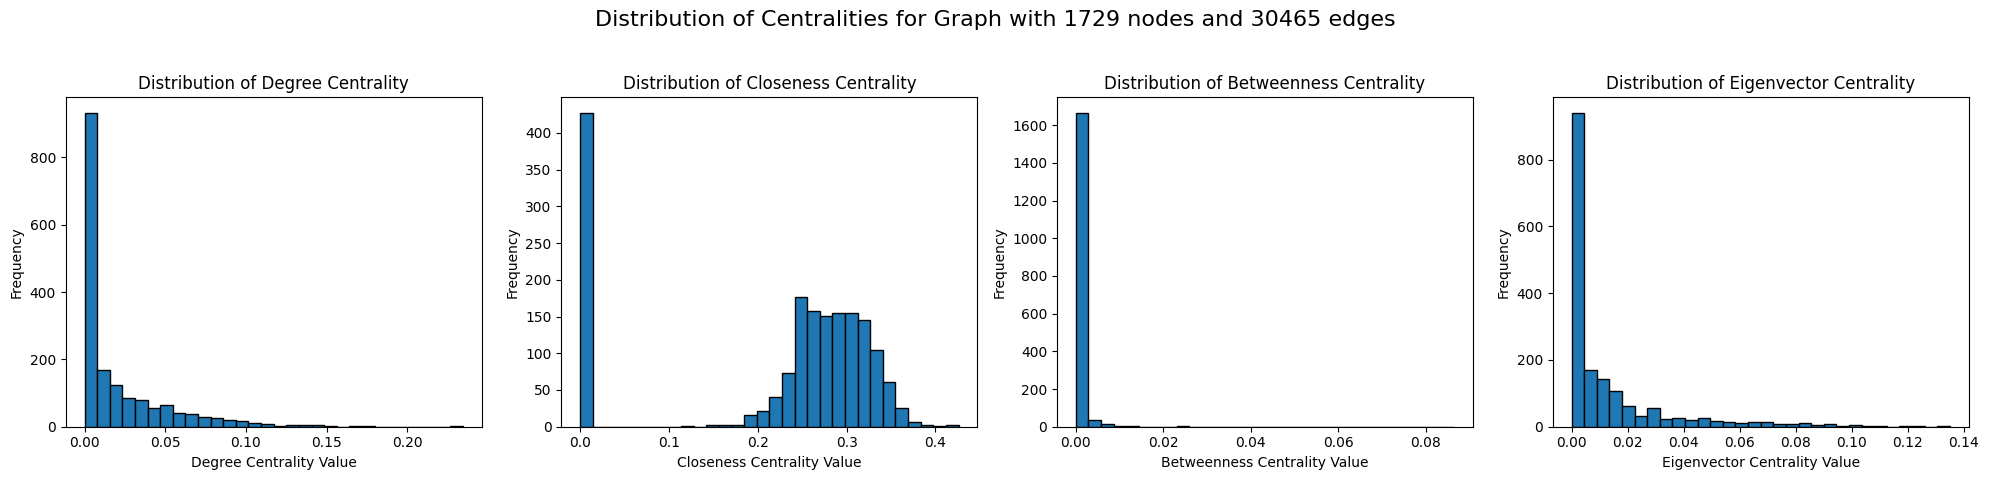

In [86]:
centralities = compute_centralities(recipes_graph)
df = pd.DataFrame(centralities)
plot_centrality_distributions(df, recipes_graph)

## Extra calculations

In [87]:


def compute_correlation(df, col1, col2):
    pearson_corr, _ = pearsonr(df[col1], df[col2])
    spearman_corr, _ = spearmanr(df[col1], df[col2])
    kendall_corr, _ = kendalltau(df[col1], df[col2])
    return pearson_corr, spearman_corr, kendall_corr

def plot_centrality_scatter_plots(df, graph_name):
    centrality_columns = [
        'degree',
        'closeness',
        'betweenness',
        'eigenvector'
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()  
    
    plot_index = 0
    for i in range(len(centrality_columns)):
        for j in range(i + 1, len(centrality_columns)):
            col1 = centrality_columns[i]
            col2 = centrality_columns[j]
            
            pearson_corr, spearman_corr, kendall_corr = compute_correlation(df, col1, col2)
            
            axes[plot_index].scatter(df[col1], df[col2], alpha=0.7)
            axes[plot_index].set_title(f'Scatter Plot: {col1} vs {col2}')
            axes[plot_index].set_xlabel(col1)
            axes[plot_index].set_ylabel(col2)
            
            axes[plot_index].text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}\nKendall: {kendall_corr:.2f}', 
                                   transform=axes[plot_index].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
            
            plot_index += 1

    plt.tight_layout()
    plt.suptitle(f'Centrality Correlations for {graph_name}', fontsize=16, y=1.02)
    plt.show()


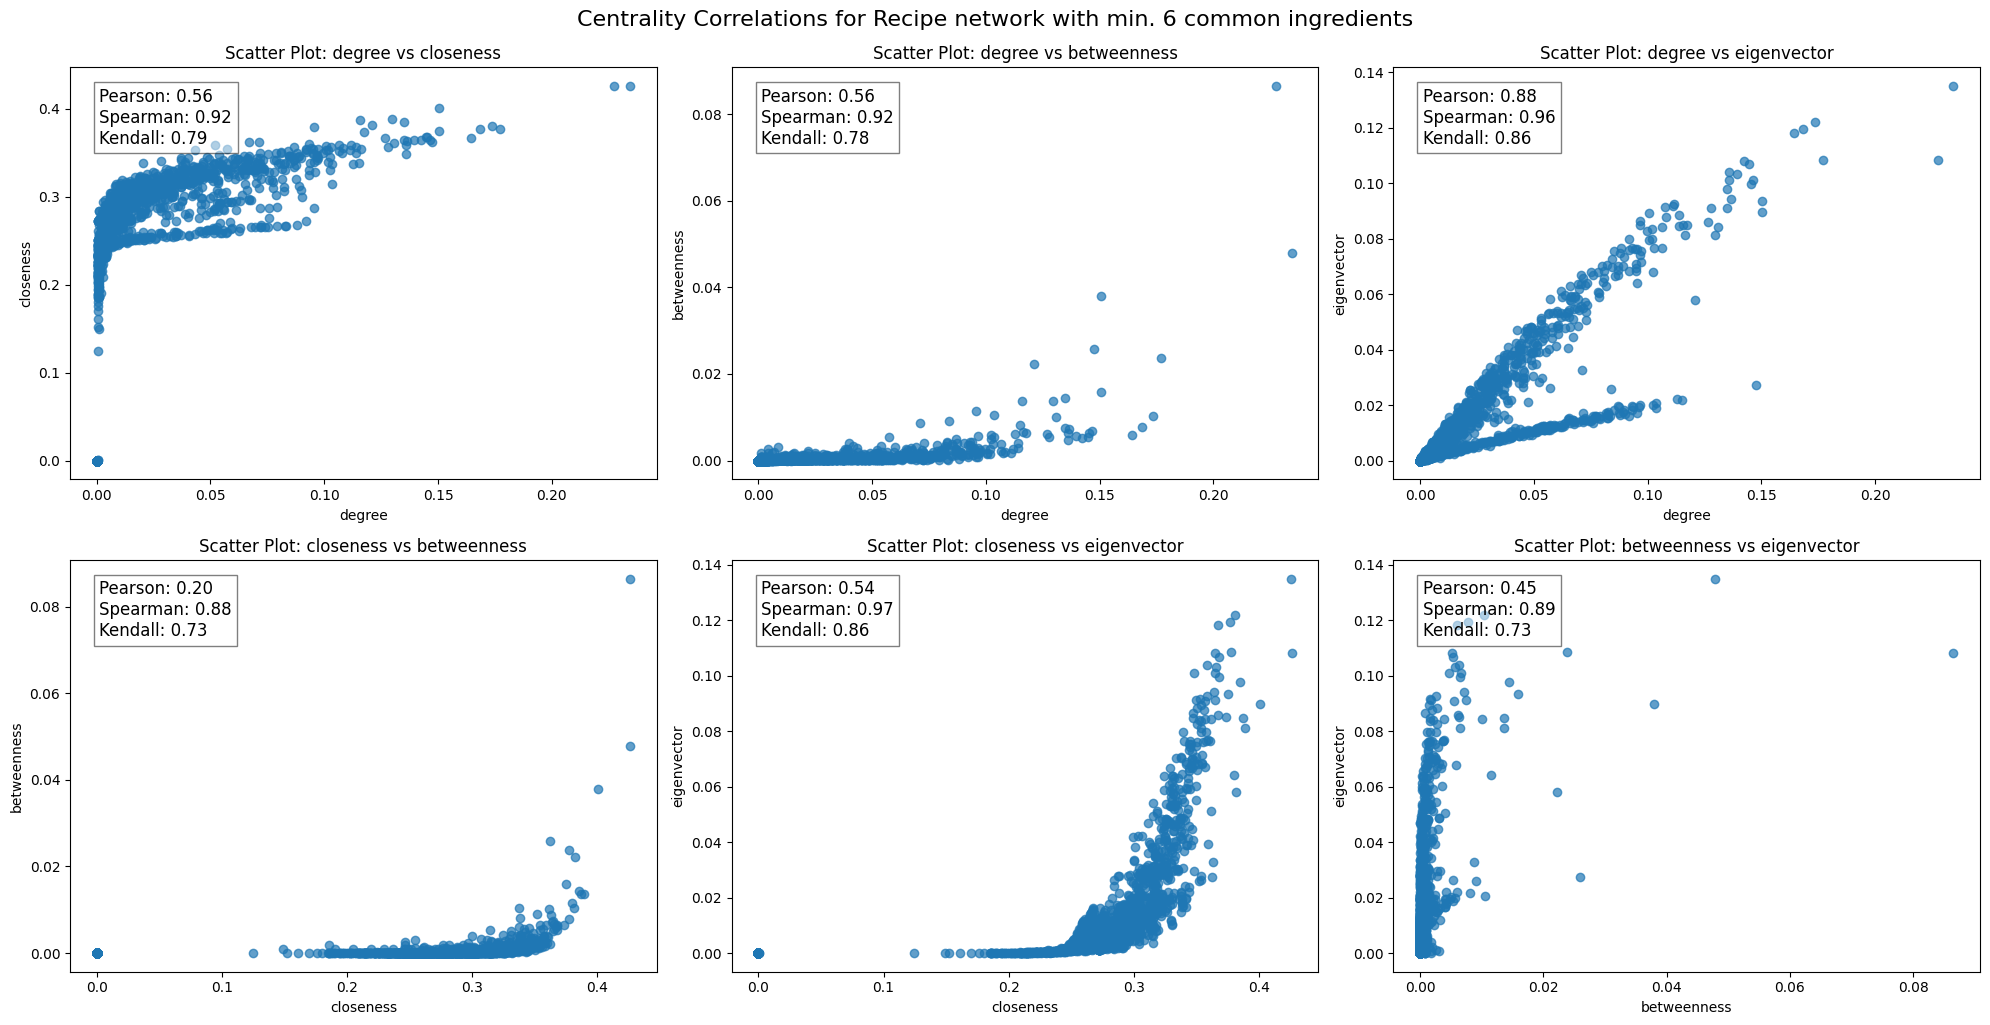

In [88]:
centralities = compute_centralities(recipes_graph)
df = pd.DataFrame(centralities)
plot_centrality_scatter_plots(df, "Recipe network with min. 6 common ingredients")

In [89]:
def compute_pearson(df1, df2, col):
    return pearsonr(df1[col], df2[col])[0]

def plot_centrality_comparisons(df_original, df_randomized, graph_name):
    centrality_types = ['degree', 'closeness', 'betweenness', 'eigenvector']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, centrality in enumerate(centrality_types):
        pearson_corr = compute_pearson(df_original, df_randomized, centrality)
        
        axes[i].scatter(df_original[centrality], df_randomized[centrality], alpha=0.7, label=f'Pearson: {pearson_corr:.2f}')
        axes[i].set_title(f'Original vs Randomized: {centrality.capitalize()}', fontsize=14)
        axes[i].set_xlabel(f'Original {centrality.capitalize()}', fontsize=12)
        axes[i].set_ylabel(f'Randomized {centrality.capitalize()}', fontsize=12)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle(f'Centrality Comparisons: Original vs Randomized ({graph_name})', fontsize=16, y=1.02)
    plt.show()


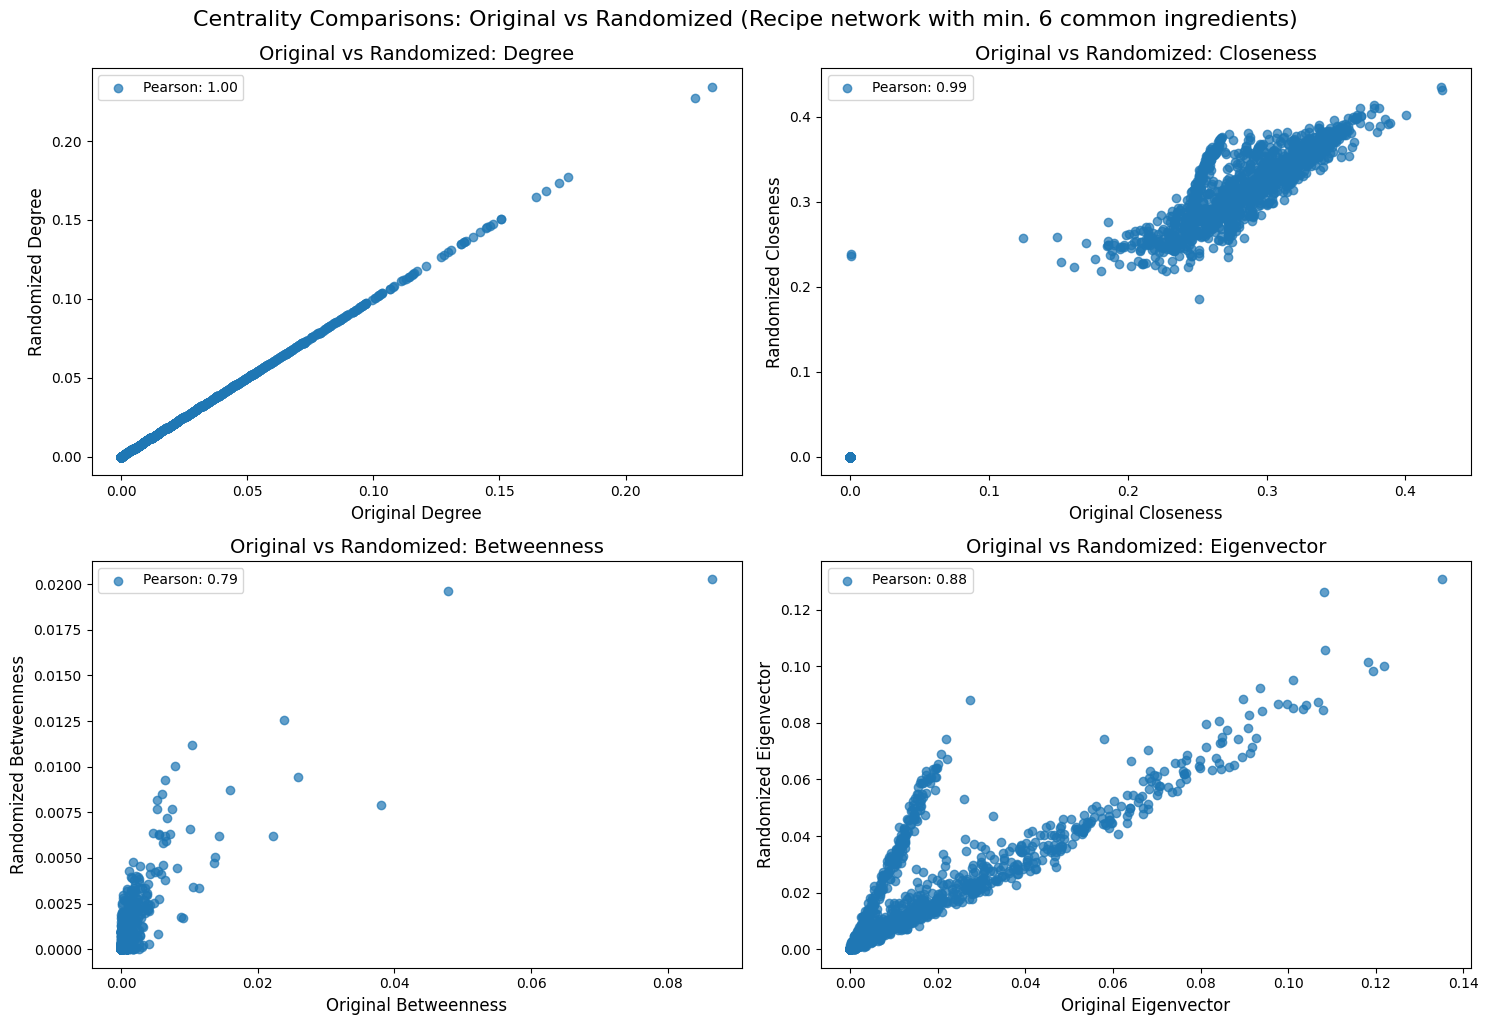

In [90]:
centralities = compute_centralities(recipes_graph)
df = pd.DataFrame(centralities)
    
randomized_graph = randomize_graph(recipes_graph)
randomized_centralities = compute_centralities(randomized_graph)
df_randomized = pd.DataFrame(randomized_centralities)
    
plot_centrality_comparisons(df, df_randomized, "Recipe network with min. 6 common ingredients")

### Observations

We can see on the plots that the Degree Centrality remains unchanged in the randomized graphs, because the degree distribution is preserved by the randomization. In case of Closeness and Betweenness Centrality we can see a lower correlation because randomization disrupts the shortest-path and flow structures. The Eigenvector Centrality also shows lower correlations but the difference is smaller, depending on how connected the nodes are in the random graph versus the original.

  
#### 1. Degree Centrality
Degree centrality measures the number of direct connections a node has within the network. A recipe with high degree centrality is one that shares a significant number of ingredients with many other recipes. These recipes likely use common ingredients and might represent versatile or foundational recipes that connect to many others.

During the randomization the edges are randomly rewired, but the node degrees remain unchanged, so the degree distribution remains the same, and therefore, the Degree Centrality remains unchanged, as the total number of connections for each node remained constant. Thats why it has 1.0 correlation.

#### 2. Closeness Centrality
Closeness centrality reflects how quickly a node can access other nodes in the network, measured by the average shortest path from that node to all others. A recipe with high closeness centrality can quickly "reach" or is closely connected to other recipes in the network. These recipes might be versatile in the sense that they use a set of ingredients that frequently appear in other recipes, making them central to the graph.

Closeness Centrality shows lower correlation because overall the shortest paths are disrupted because of the randomization.

#### 3. Betweenness Centrality
Betweenness centrality measures the extent to which a node serves as a bridge along the shortest paths between other nodes. Nodes with high betweenness centrality are critical for information flow or connectivity, acting as intermediaries. A recipe with high betweenness centrality acts as a "bridge" between clusters of recipes. These recipes likely share ingredients with multiple distinct groups of recipes and could play a crucial role in connecting different cuisines or cooking styles.

The Betweenness Centrality is also affected by the randomization because when the network is randomized shortest paths are removed or altered, and the nodes that served as intermediaries may no longer fulfill this role. This highlights the sensitivity of betweenness centrality to network structure. 

#### 4. Eigenvector Centrality
Eigenvector centrality evaluates a node's influence based not just on the number of connections but also on the quality and influence of its neighbors. A node connected to other well-connected nodes scores higher. A recipe with high eigenvector centrality is connected to other influential recipes. These recipes are central to the overall structure of the graph and might represent dishes with ingredients that are foundational to many popular or versatile recipes.

With the Eigenvector Centrality the correlation is affected less by the randomization,because it depends on how well the randomization maintains the overall connectivity and flow of importance across nodes. While randomization may disrupt connections, eigenvector centrality continues to reflect the influence of nodes based on their connections to other significant nodes.

#### Observed Differences and Similarities

Degree centrality remained stable in all cases, while closeness, betweenness, and eigenvector centralities were significantly affected by randomization, showcasing how the specific structure of the network influences the sensitivity of different centrality measures.


In [91]:
def plot_fit(G):
    degrees = [degree for _, degree in G.degree()]

    degrees = [d for d in degrees if d > 0]

    if len(degrees) == 0:
        print("No degrees greater than zero in the graph.")
        return

    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.alpha
    xmin = fit.xmin

    alpha_error = fit.sigma

    print(f"Alpha Error: {alpha_error}")
    print(f"Fitted alpha: {alpha}")

    lam = np.mean(degrees)

    hist, bin_edges = np.histogram(
        degrees,
        bins=np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=40),
        density=True
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if np.any(np.isnan(hist)):
        print("Histogram contains NaN values. Check degree distribution.")
        return

    degree_values = np.arange(1, max(degrees) + 1)
    poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)
    exponential_prob = (1 / lam) * np.exp(-degree_values / lam)

    plt.figure(figsize=(7, 5))

    plt.loglog(bin_centers, hist, 'o', color='blue', markersize=5, label="Empirical Data")
    fit.power_law.plot_pdf(color='red', label=f"Power-Law Fit (α={alpha:.2f})")
    plt.loglog(degree_values, poisson_prob, 'g-', label=f'Poisson Fit (λ = {lam:.2f})')
    plt.loglog(degree_values, exponential_prob, 'm-', label=f'Exponential Fit (λ = {lam:.2f})')

    plt.xlabel("Degree (k)", fontsize=12)
    plt.ylabel("Probability (p(k))", fontsize=12)
    plt.title("Empirical Degree Distribution with Power-Law, Poisson, and Exponential Fits", fontsize=14)
    plt.legend()

    max_empirical_prob = np.nanmax(hist) 
    if max_empirical_prob > 0:
        plt.ylim(1e-6, max_empirical_prob * 1.1)
    else:
        print("Maximum empirical probability is zero or invalid.")
        return

    plt.show()


Calculating best minimal value for power law fit
Alpha Error: 0.4490565266508337
Fitted alpha: 5.091099659333662


/var/folders/2j/w5gyp6sx2xqdbzcqb6l19dvr0000gn/T/ipykernel_70793/3553165567.py:33: RuntimeWarning: overflow encountered in power
  poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)
/var/folders/2j/w5gyp6sx2xqdbzcqb6l19dvr0000gn/T/ipykernel_70793/3553165567.py:33: RuntimeWarning: invalid value encountered in divide
  poisson_prob = (lam ** degree_values * np.exp(-lam)) / factorial(degree_values)


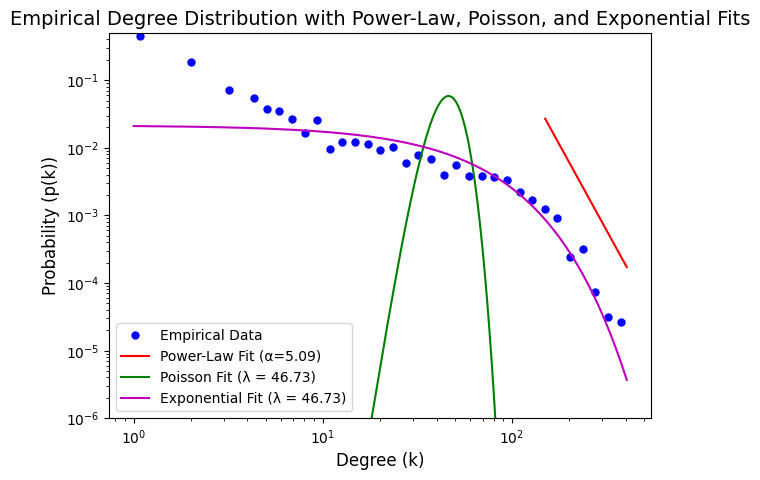

In [92]:
plot_fit(recipes_graph)